<a href="https://colab.research.google.com/github/gamecicn/TF2_Study/blob/NeteaseCourse/T2C7_Time_Series_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## T2C7 Time Series Prediction 

In [3]:
import warnings
warnings.filterwarnings("ignore")
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [19]:
df = pd.read_csv('/content/drive/MyDrive/DS_data/TensorFlowEx/TimeSeries/jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [20]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [21]:
# 前30W个样本数据当做训练的，剩余的当做验证集

TRAIN_SPLIT = 300000
tf.random.set_seed(13)

### 单特征训练模型

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3daba26be0>],
      dtype=object)

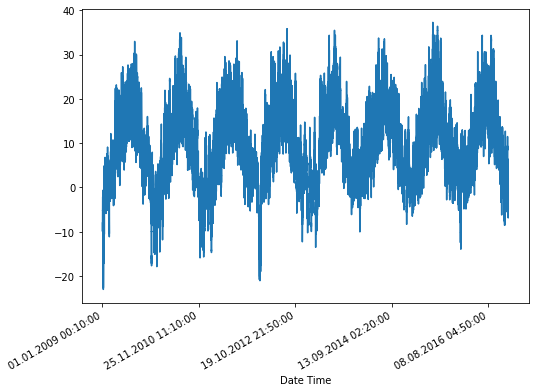

In [22]:
#只选一个温度特征
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

uni_data.plot(subplots=True)

### 数据预处理：标准化操作

In [23]:
uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std

窗口大小为20条数据，预测一个时刻的气温

In [24]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

数据与标签维度

In [25]:
x_train_uni.shape
y_train_uni.shape

(299980,)

In [26]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


### 时间序列样本展示

In [27]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [28]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

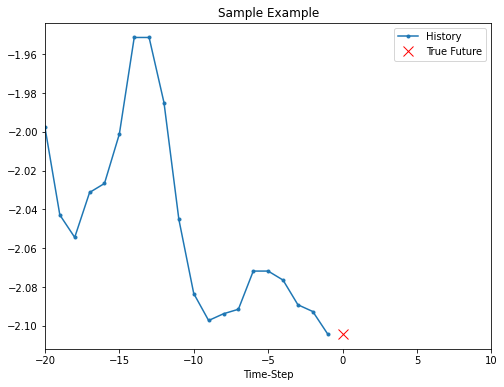

In [29]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### 最差也得比平均强吧

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

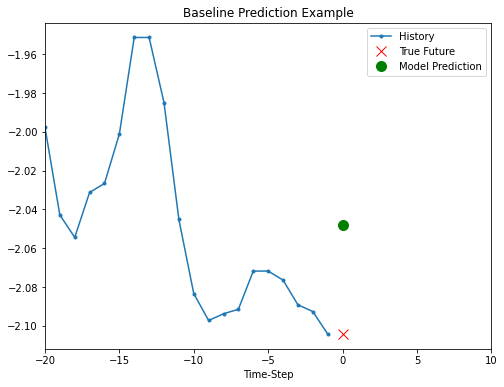

In [30]:
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,'Baseline Prediction Example')

### 构建RNN模型进行预测

In [32]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [33]:
train_univariate

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

In [34]:
x_train_uni.shape[-2:]

(20, 1)

LSTM模型

In [36]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [37]:
# 得到一个batch的测试结果

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [38]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 11ms/step - loss: 0.5855 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1559 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0505 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0510 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0271 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0289 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0312 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0280 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0256 - val_loss: 0.0181
Epoch 10/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0239 - val_loss: 0.0

### 用训练好的模型预测结果

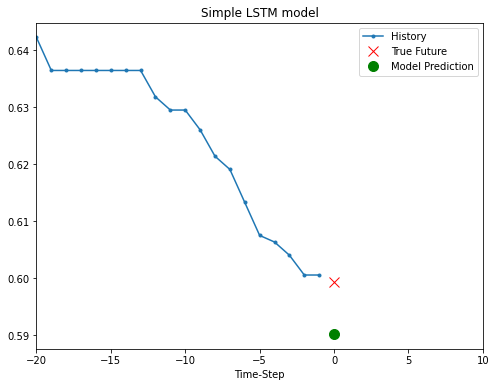

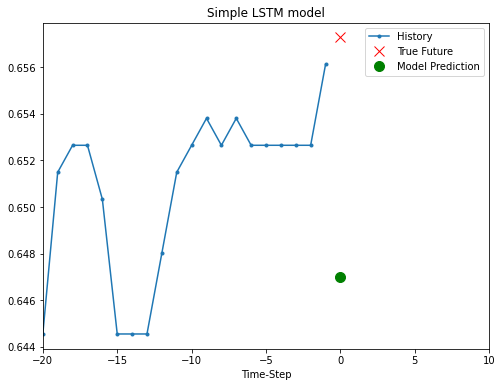

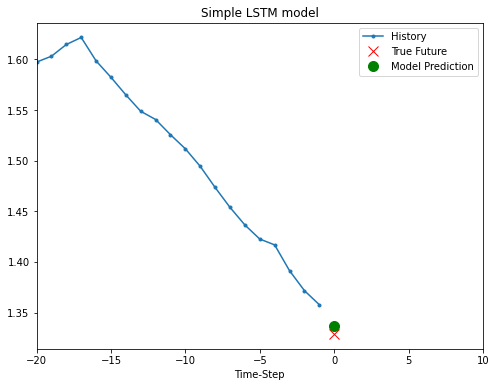

In [39]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

### 多用些特征看看效果

In [40]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3da62a0fd0>,
      dtype=object)

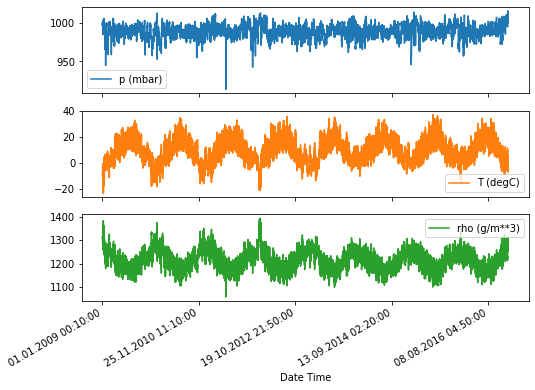

In [41]:
features.plot(subplots=True)

标准化的时候只能用训练数据

In [44]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

### 时间窗口数据制作
- 只预测接下来一个时间点的结果

In [45]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step) #索引为range(0, 720, 6)，range(1, 721, 6) range(2, 722, 6)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size]) #（720+72）（721+72）
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

- 选择训练窗口为5天的数据，5  * 24 乘 6=720条记录
- step=6表示每6隔6个时间点实际取一次数据，即窗口大小：720/6=120 ，索引为range(0, 720, 6)，range(0, 720, 6)
- 要预测的结果（标签）为12小时后的温度值，即12*6=72,72个时间点后的结果

In [46]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
x_train_single.shape

In [ ]:
y_train_single.shape

### 构建训练数据

In [47]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [48]:
train_data_single

<RepeatDataset shapes: ((None, 120, 3), (None,)), types: (tf.float64, tf.float64)>

In [49]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [50]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [51]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 20s 90ms/step - loss: 0.3622 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 18s 91ms/step - loss: 0.2684 - val_loss: 0.2421
Epoch 3/10
200/200 [==============================] - 18s 88ms/step - loss: 0.2656 - val_loss: 0.2448
Epoch 4/10
200/200 [==============================] - 19s 97ms/step - loss: 0.2630 - val_loss: 0.2447
Epoch 5/10
200/200 [==============================] - 19s 94ms/step - loss: 0.2202 - val_loss: 0.2368
Epoch 6/10
200/200 [==============================] - 19s 94ms/step - loss: 0.2454 - val_loss: 0.2658
Epoch 7/10
200/200 [==============================] - 20s 99ms/step - loss: 0.2428 - val_loss: 0.2565
Epoch 8/10
200/200 [==============================] - 20s 100ms/step - loss: 0.2426 - val_loss: 0.2381
Epoch 9/10
200/200 [==============================] - 20s 99ms/step - loss: 0.2488 - val_loss: 0.2480
Epoch 10/10
200/200 [==============================] - 20s 101ms/step - loss: 0.2

### 训练结果展示

In [53]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

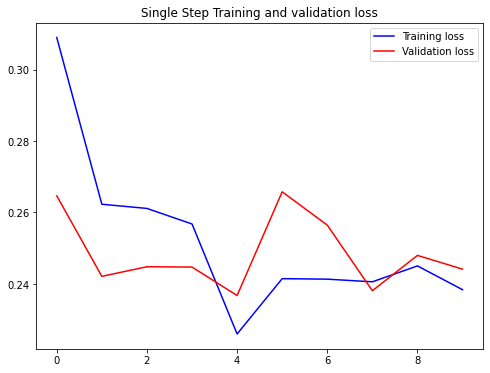

In [54]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

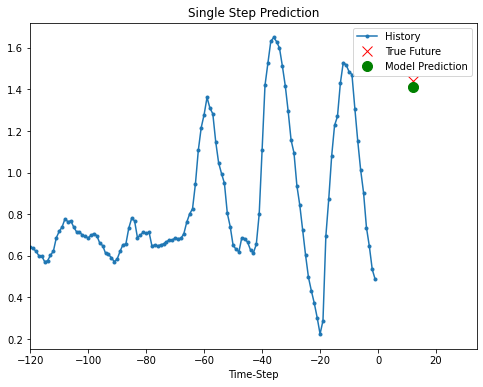

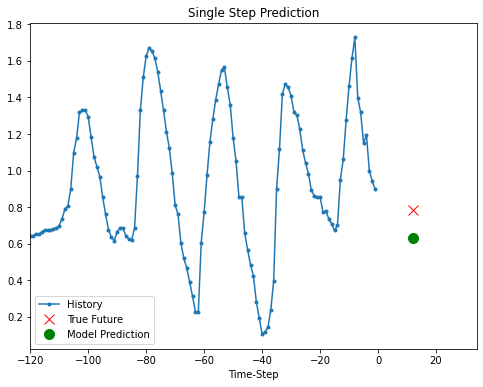

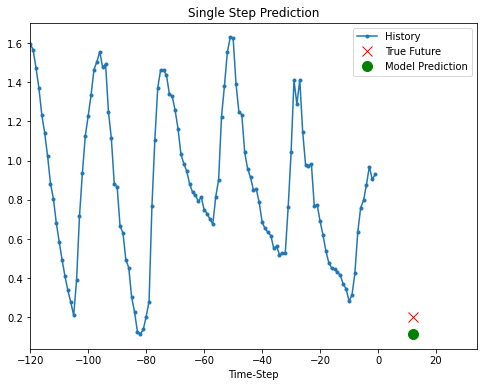

In [55]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

### 预测接下来一个时间片段的结果

In [56]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [57]:
x_train_multi.shape

(299280, 120, 3)

In [58]:
y_train_multi.shape

(299280, 72)

In [60]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

要预测的序列

In [61]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

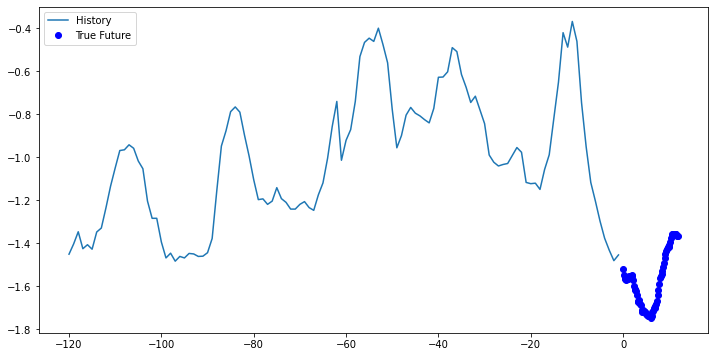

In [62]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

2层的LSTM网络，预测72个时间结果

In [63]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

每个序列输入后都会得到72个预测结果

In [64]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [65]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 36s 160ms/step - loss: 7.7122 - val_loss: 43.5504
Epoch 2/10
200/200 [==============================] - 32s 159ms/step - loss: 77.6184 - val_loss: 0.5989
Epoch 3/10
200/200 [==============================] - 34s 171ms/step - loss: 0.7901 - val_loss: 0.2906
Epoch 4/10
200/200 [==============================] - 33s 167ms/step - loss: 0.3471 - val_loss: 0.2522
Epoch 5/10
200/200 [==============================] - 33s 163ms/step - loss: 2.9296 - val_loss: 0.2957
Epoch 6/10
200/200 [==============================] - 33s 167ms/step - loss: 0.2832 - val_loss: 0.2339
Epoch 7/10
200/200 [==============================] - 36s 180ms/step - loss: 0.2336 - val_loss: 0.2249
Epoch 8/10
200/200 [==============================] - 36s 178ms/step - loss: 0.2238 - val_loss: 0.2090
Epoch 9/10
200/200 [==============================] - 36s 179ms/step - loss: 0.2214 - val_loss: 0.2100
Epoch 10/10
200/200 [==============================] - 36s 180ms/step -

### 预测结果展示

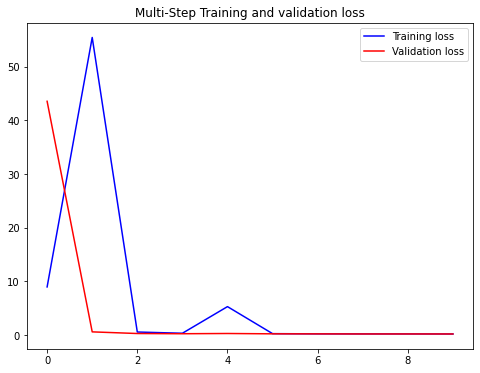

In [66]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

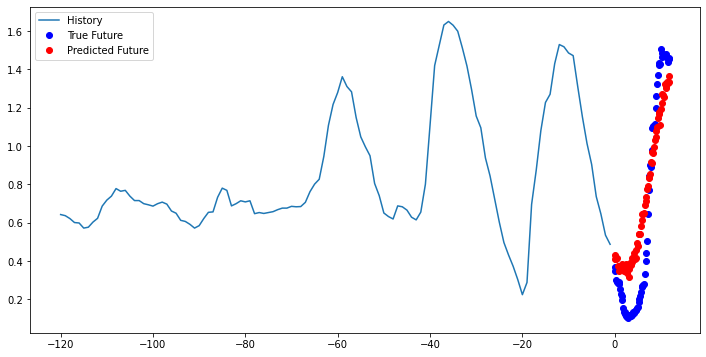

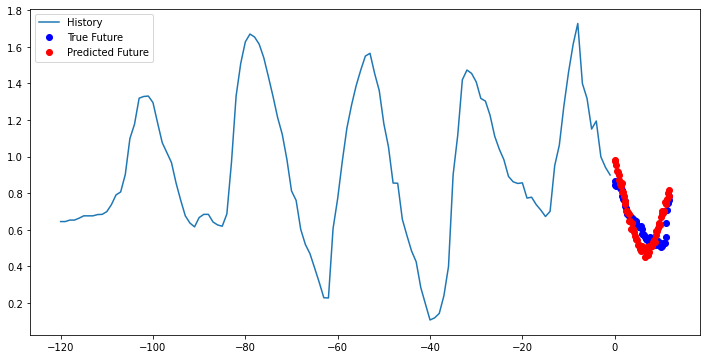

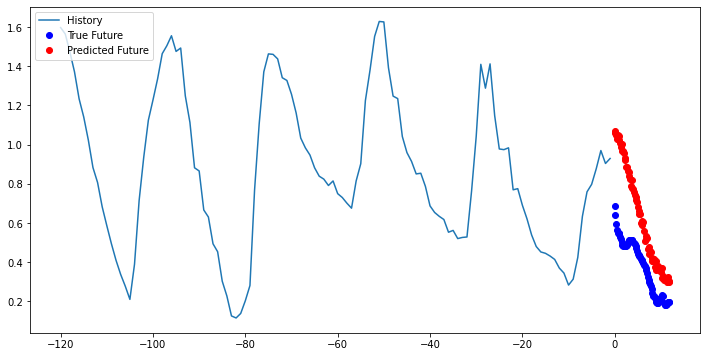

In [67]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])